# Домашнее задание по теме "Знакомство с временными рядами" 
## Задание

нужно проанализировать 6 временных рядов:
- “monthly-sales-of-company-x-jan-6.csv”, 
- “monthly-boston-armed-robberies-j.csv”, 
- “international-airline-passengers.csv”, 
- “mean-monthly-air-temperature-deg.csv”, 
- “weekly-closings-of-the-dowjones-.csv”, 
- "daily-total-female-births-in-cal.csv"

какие-то будут изначально стационарными, к каким-то нужно применить преобразования и добиться стационарности.


## Импорт библиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
%matplotlib inline

## Используемые функции


In [16]:
def test_stationarity(timeseries):
    '''Функция выдаёт результаты теста Дика-Фуллера(p-value, статистику, количество лагов, количество точек) на стационарность'''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    '''Функция выдаёт результаты теста Дика-Фуллера при помощи функции test_stationarity.
    Проверяет принадлежность объекта указнному классу(в данном случае pd.Series)
    Затем выводит 3 графика: временной ряд, автокорелляция, частитчная автокорелляция перед этим идёт настройка поля отображения'''
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

## Данные

In [3]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [8]:
sales_of_company_x.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [9]:
robberies_in_boston.head()

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [10]:
airlines_passengers.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [11]:
mean_monthly_temp.head()

,Month,Deg
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [12]:
dowjones_closing.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [13]:
female_births.head()

,Date,Count
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


## Решение. Проверка на стационарность и применение стационарности.

Для начала будем искать в каждом временном ряде: сезонность, тренд. Далее постепенно убирая эти признаки нестационарноти и проверяя по тесту Дикки-Фуллера, будем отвергать гипотезу о нестационарности ряда.
Первоначально:
H0 : ряд нестационарный
H1 : ряд стационарный

In [19]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Daily total female births in California": female_births["Count"]
}

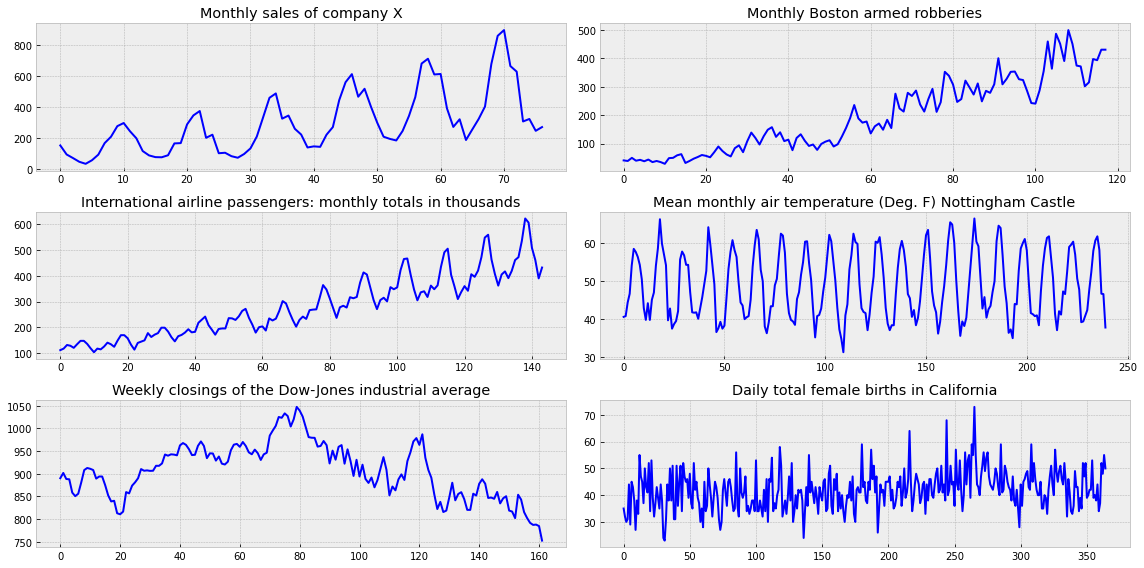

In [20]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

Визуально можно оценить в каких временных рядах, какие признаки нестационарности у нас есть (сезонность, тренд).
  1. "Monthly sales of company X": сезонность + тренд
  1. "Monthly Boston armed robberies": тренд
  1. "International airline passengers: сезонность + тренд
  1. "Mean monthly air temperature (Deg. F) Nottingham Castle": сезонность
  1. "Weekly closings of the Dow-Jones industrial average": вроде ничего нет, но надо проверить статистически по тесту Дика-Фуллера
  1. "Daily total female births in California": похоже на присутствие, но надо проверить статистически по тесту Дика-Фуллера

##### Проверим стационарность всех датасетов по тесту Дика-Фуллера, чтобы убедиться или разубедиться в выводах, сделанных на основе визуаизаций.

In [32]:
for key, dataset in all_series.items():
    print('{}'.format(key))
    test_stationarity(all_series[key])
    print()

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64

Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critic

По результатам теста видно, что два временных ряда уже являются стационарными, судь по их p-value < 0.05 и это 
1. Mean monthly air temperature (Deg. F) Nottingham Castle - mean_monthly_temp["Deg"]
1. Daily total female births in California -  female_births["Count"]

Построим их кореллограммы

## 1

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


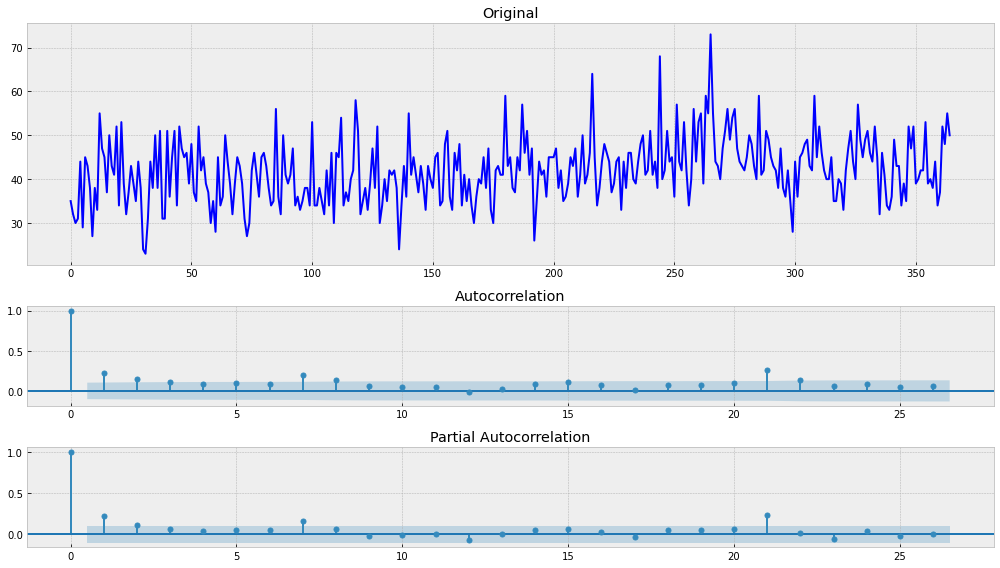

In [40]:
tsplot( female_births["Count"])

### Теперь видно по тесту и по кореллограммам, что данные временной ряд - female_births["Count"] является стационарным.

## 2

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


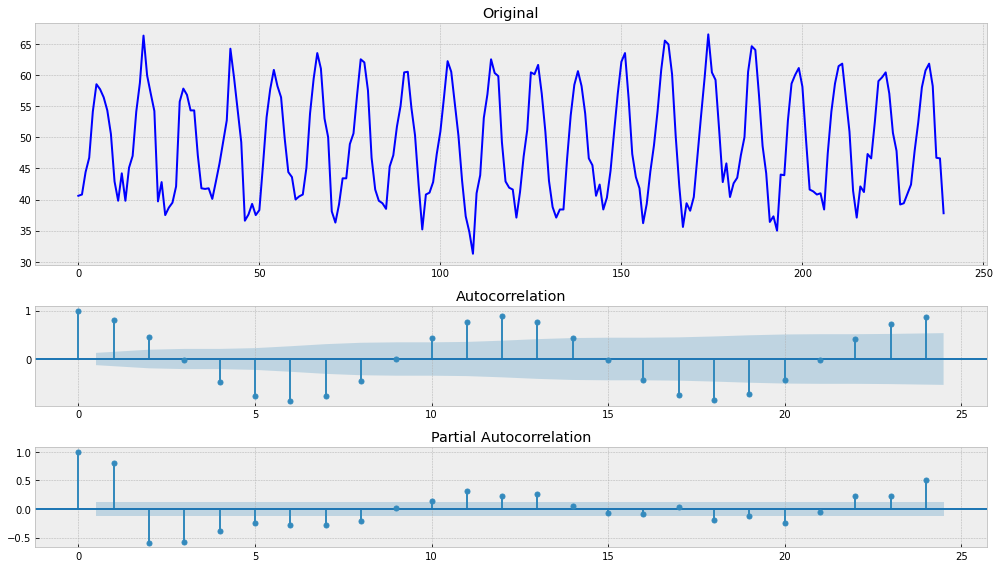

In [39]:
tsplot( mean_monthly_temp["Deg"])

Здесь по кореллограммам видно, что присутствует сезонность, которая вносит своё влияние. Уберём её, используя дифференцирование.

Results of Dickey-Fuller Test:
Test Statistic                -1.041098e+01
p-value                        1.804502e-18
#Lags Used                     1.500000e+01
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


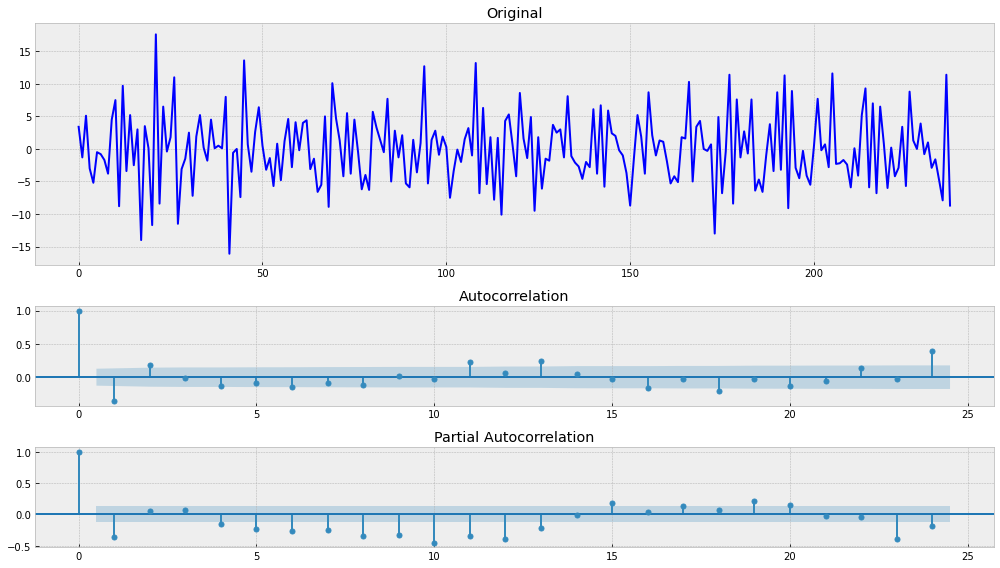

In [85]:
tsplot(np.diff(mean_monthly_temp["Deg"], 2))

### Теперь видно по тесту и по кореллограммам, что данные временной ряд -mean_monthly_temp["Deg"] является стационарным.

In [103]:
all_series_2 = all_series

In [104]:
[all_series_2.pop(key) for key in ['Mean monthly air temperature (Deg. F) Nottingham Castle', 'Daily total female births in California']]

KeyError: 'Mean monthly air temperature (Deg. F) Nottingham Castle'

In [106]:
all_series_2.keys()

dict_keys(['Monthly sales of company X', 'Monthly Boston armed robberies', 'International airline passengers: monthly totals in thousands', 'Weekly closings of the Dow-Jones industrial average'])

## 3

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\first\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


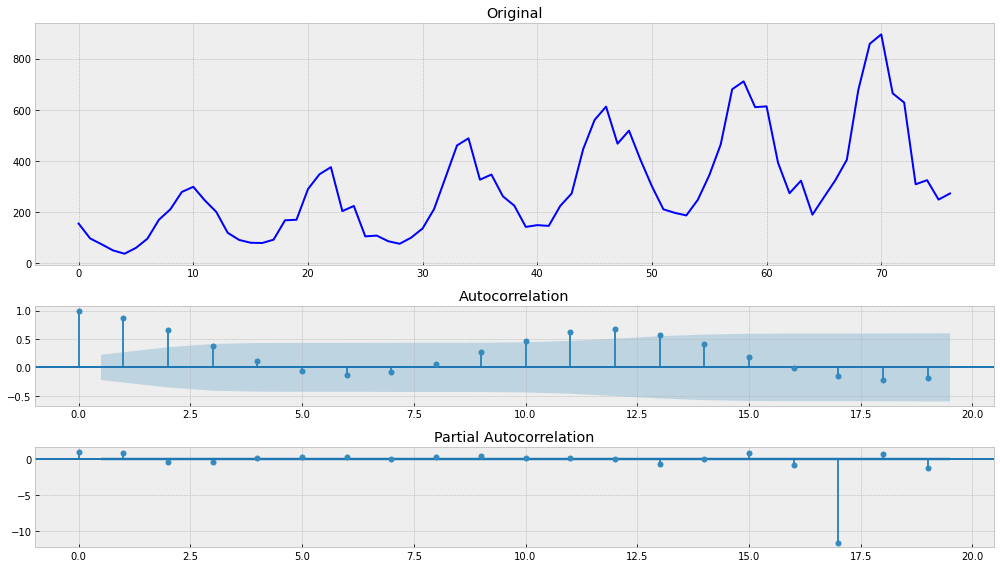

In [109]:
tsplot(all_series_2['Monthly sales of company X'])

Как мы видим, и тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [113]:
gr_1 = boxcox(all_series_2["Monthly sales of company X"], 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


C:\Users\first\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


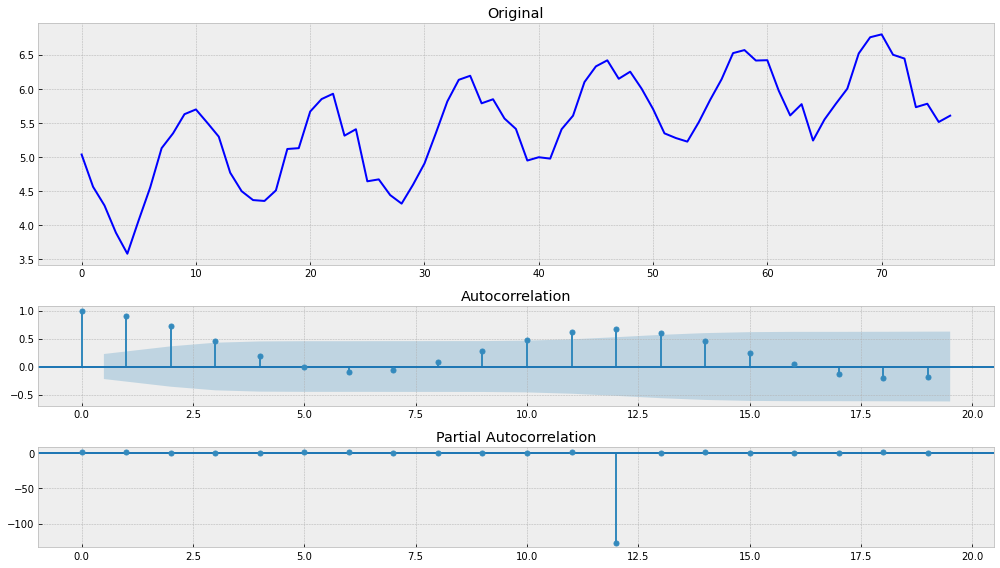

In [114]:
tsplot(gr_1)

Удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.

Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


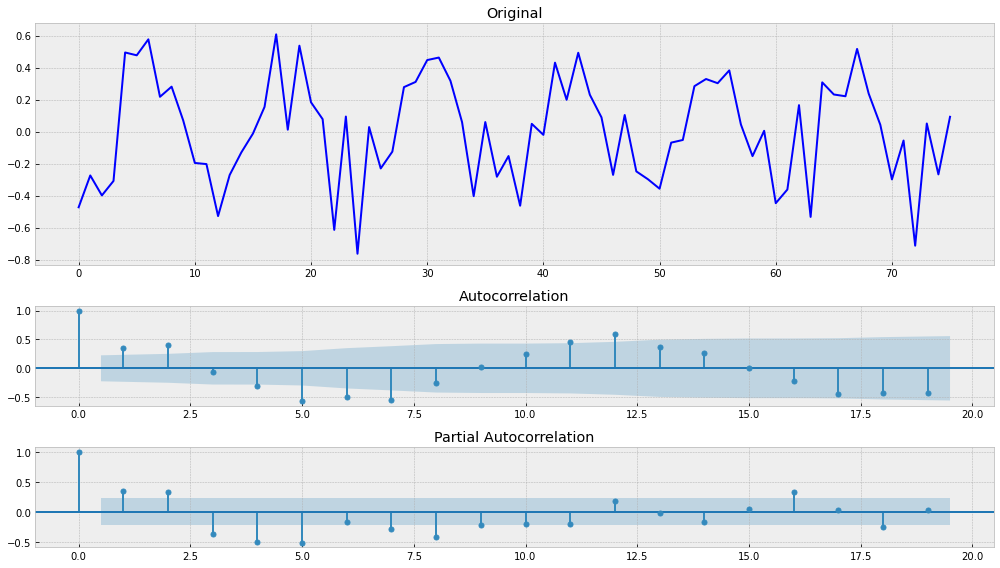

In [115]:
tsplot(np.diff(gr_1, 1))

### Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!

## 4

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


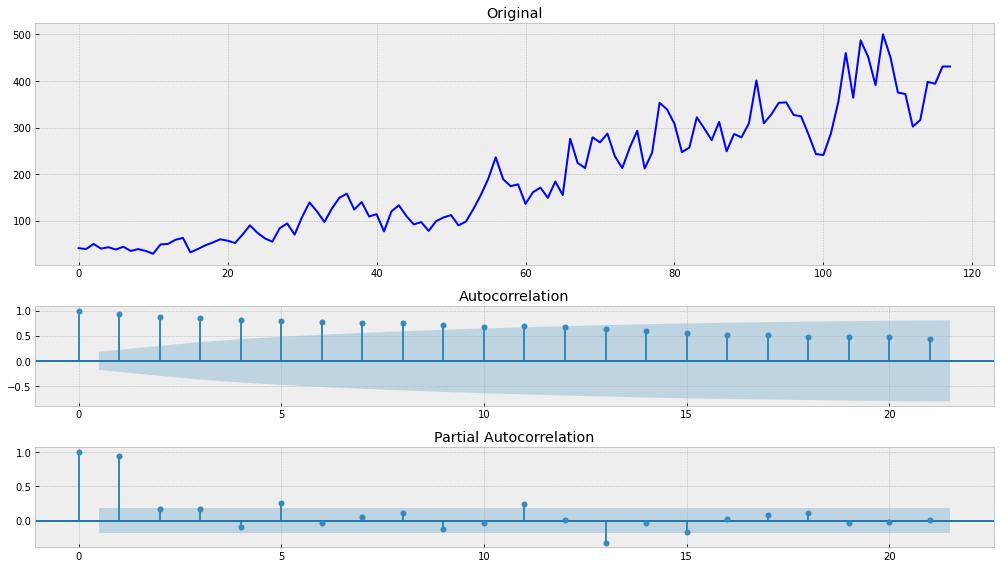

In [116]:
tsplot(all_series_2["Monthly Boston armed robberies"])

По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.

In [117]:
gr_2 = np.diff(all_series_2["Monthly Boston armed robberies"], 1)

Results of Dickey-Fuller Test:
Test Statistic                -7.428564e+00
p-value                        6.450795e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64


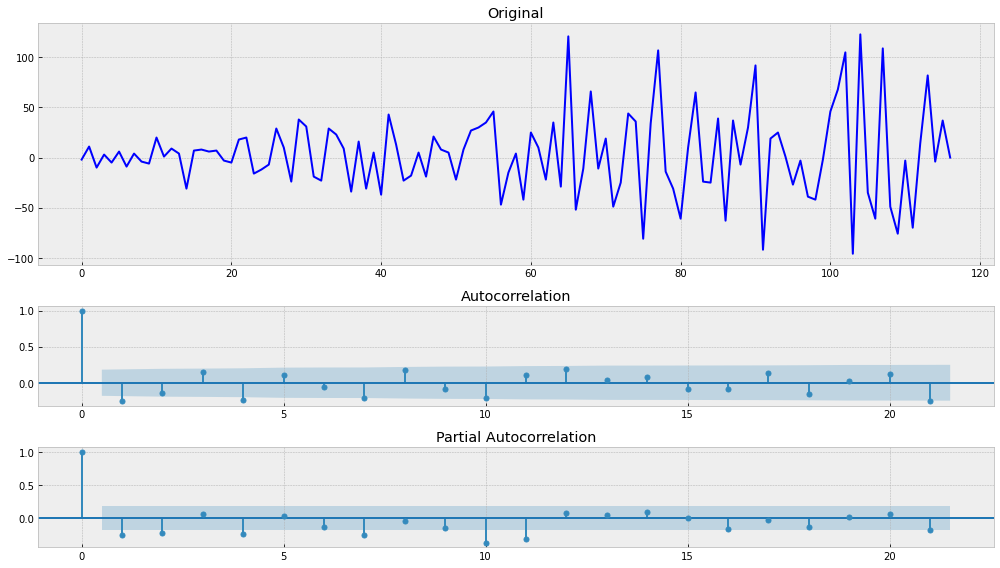

In [118]:
tsplot(gr_2)

### Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!

## 5

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


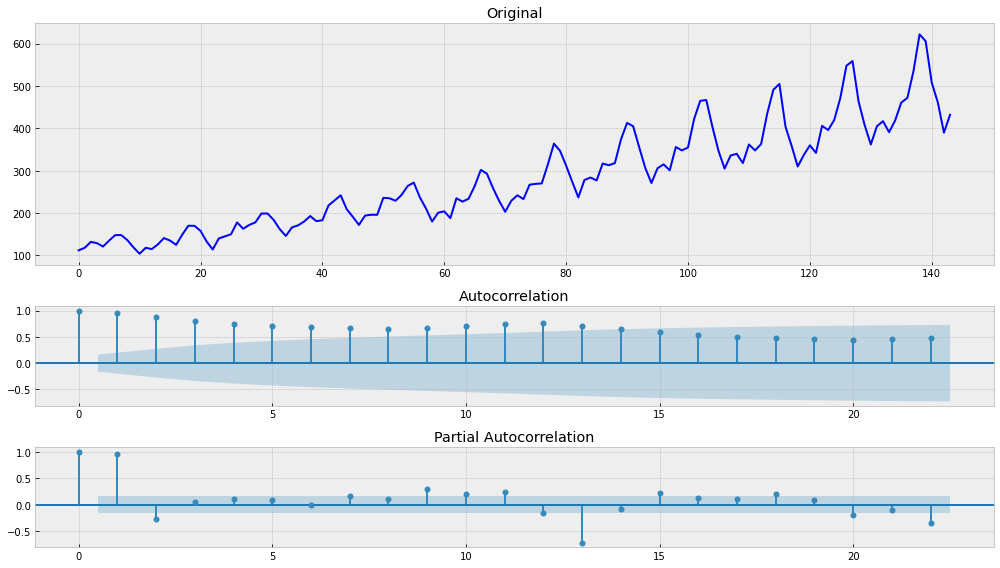

In [119]:
tsplot(all_series_2["International airline passengers: monthly totals in thousands"])

Как мы видим, и тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. 
Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.

In [128]:
gr_3 = np.diff(boxcox(all_series_2["International airline passengers: monthly totals in thousands"], 0), 2)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


C:\Users\first\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


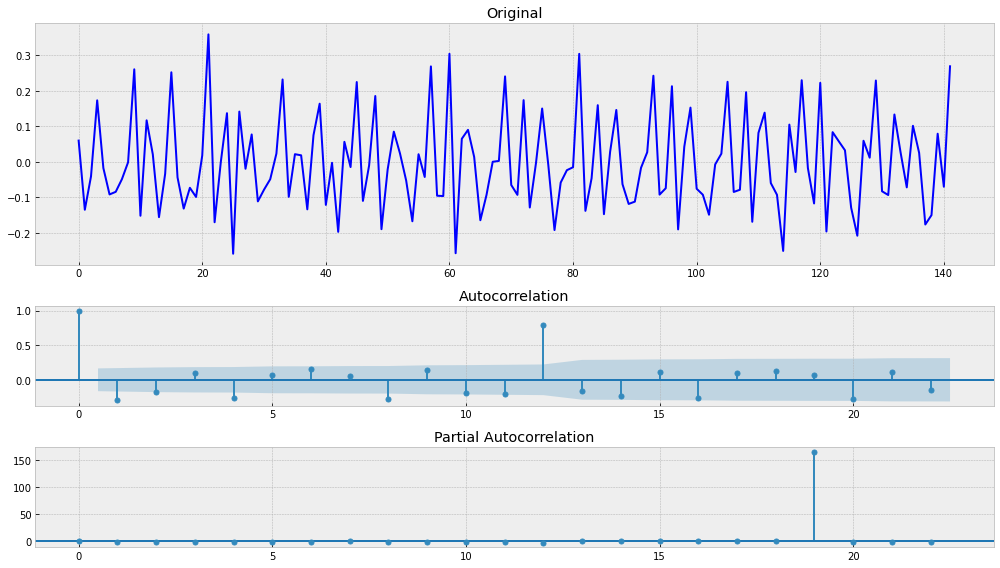

In [129]:
tsplot(gr_3)

### Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!

## 6

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


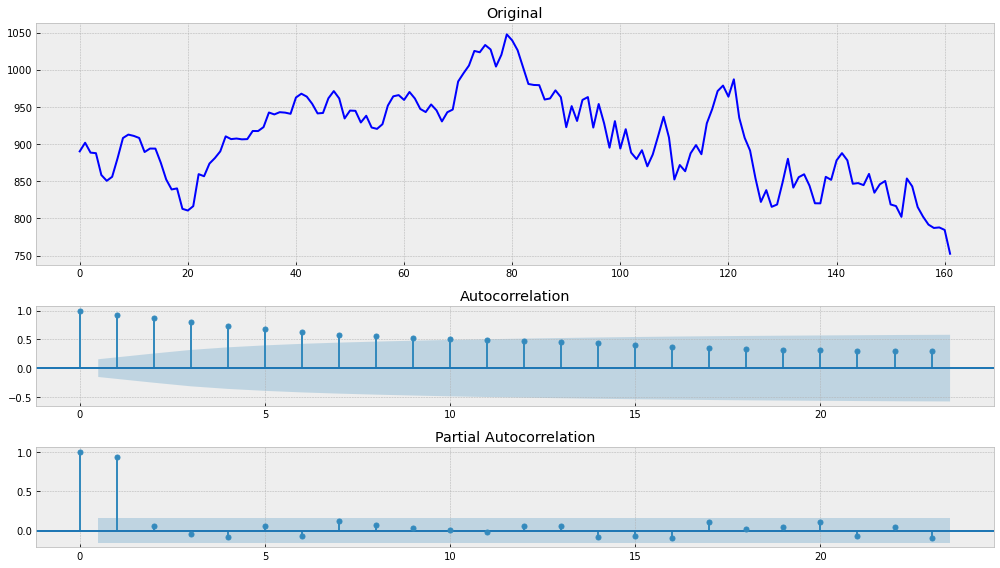

In [130]:
tsplot(all_series_2["Weekly closings of the Dow-Jones industrial average"])

Здесь тест Дики-Фуллера не отвергает гипотезу о нестационарности ряда, чего не скажешь о графиках коррелограмм . Попробуем исправить ситуацию дифференцированием.

In [135]:
gr_4 = np.diff(all_series_2["Weekly closings of the Dow-Jones industrial average"], 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


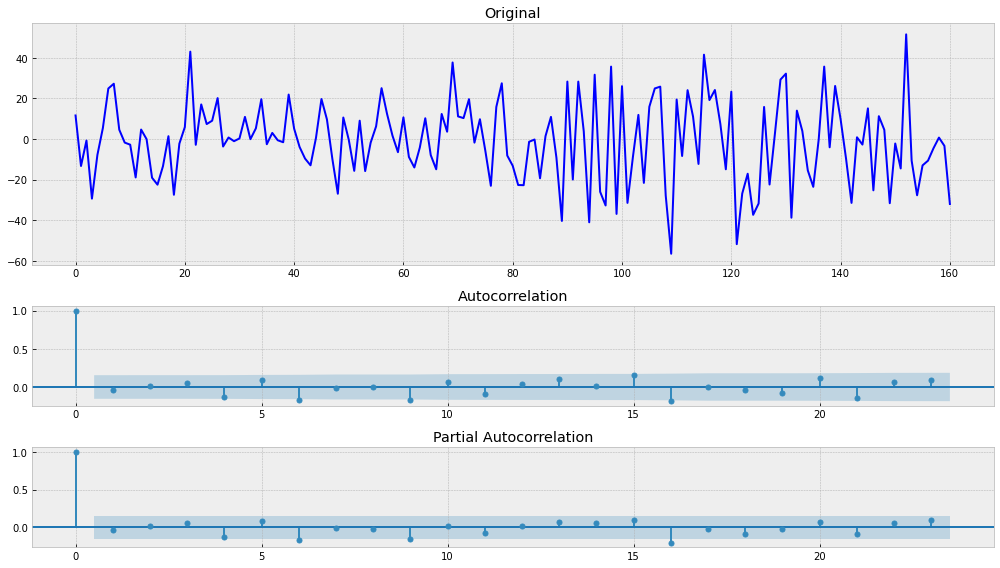

In [136]:
tsplot(gr_4)

### Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!